# XGBoost Model for Poverty Risk Prediction

This notebook handles preprocessing and training an XGBoost model.

## Key Differences from Logistic Regression Baseline
- XGBoost handles missing values **natively** - no need to impute
- XGBoost doesn't require one-hot encoding - can use label encoding or native categorical support
- XGBoost is less sensitive to feature scaling - no need for StandardScaler
- XGBoost handles non-linear relationships and interactions automatically

In [1]:
!pip install xgboost -q


[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load Data
df_train = pd.read_csv('preprocessing_data/train_data_final_feat_no_preprocessing.csv')
df_test = pd.read_csv('preprocessing_data/test_data_final_feat_no_preprocessing.csv')

print(f"Train shape: {df_train.shape}")
print(f"Test shape: {df_test.shape}")
print(f"\nColumns: {list(df_train.columns)}")

Train shape: (1469769, 27)
Test shape: (304368, 27)

Columns: ['PUMA', 'AGEP', 'CIT', 'ENG', 'LANX', 'MAR', 'MIG', 'SCHL', 'SEX', 'WKHP', 'WKL', 'WRK', 'DIS', 'ESR', 'HICOV', 'LANP', 'MSP', 'NATIVITY', 'OCCP', 'POBP', 'POVPIP', 'PRIVCOV', 'PUBCOV', 'RAC1P', 'year', 'poverty_risk_score', 'CA_Region']


## 1. Null Value Analysis

Understanding WHY values are null is critical for proper handling.

In [4]:
# Null analysis
def analyze_nulls(df, name="Dataset"):
    null_counts = df.isnull().sum()
    null_pct = (null_counts / len(df) * 100).round(2)
    null_df = pd.DataFrame({
        'null_count': null_counts,
        'null_pct': null_pct
    })
    null_df = null_df[null_df['null_count'] > 0].sort_values('null_pct', ascending=False)
    print(f"=== {name} Null Analysis ===")
    print(null_df)
    return null_df

train_nulls = analyze_nulls(df_train, "Training Set")
print("\n")
test_nulls = analyze_nulls(df_test, "Test Set")

=== Training Set Null Analysis ===
      null_count  null_pct
ENG       846170     57.57
LANP      846170     57.57
WKHP      516033     35.11
OCCP      376902     25.64
WRK       168637     11.47


=== Test Set Null Analysis ===
      null_count  null_pct
ENG       171914     56.48
LANP      171914     56.48
WKHP      108226     35.56
OCCP       79185     26.02
WRK        38061     12.50


## 2. Understanding Null Patterns

The nulls in this dataset are **NOT random** - they represent meaningful "Not Applicable" (N/A) cases:

| Feature | Why Null | ACS Code Meaning |
|---------|----------|------------------|
| **ENG** | Person speaks only English at home (LANX=2) | Ability to speak English - N/A for English-only speakers |
| **LANP** | Person speaks only English at home (LANX=2) | Language spoken at home - N/A for English-only speakers |
| **WKHP** | Person didn't work (not in labor force) | Usual hours worked per week - N/A for non-workers |
| **OCCP** | Person is not employed | Occupation code - N/A for unemployed/NILF |
| **WRK** | Various reasons (age, GQ status) | Worked in past 12 months |

### Strategy Options:

**Option A: Let XGBoost handle nulls natively**
- XGBoost learns optimal split direction for missing values
- Simple, no information loss
- Recommended for tree-based models

**Option B: Create explicit "Not Applicable" categories**
- Replace nulls with meaningful codes (e.g., OCCP null → "NILF")
- More interpretable
- Useful if you want to understand feature importance

In [5]:
# Verify null patterns - ENG/LANP should be null when LANX=2 (English only)
print("ENG null when LANX==2 (English only):", 
      df_train[df_train['LANX'] == 2]['ENG'].isnull().mean() * 100, "%")

print("ENG null when LANX==1 (Other language):", 
      df_train[df_train['LANX'] == 1]['ENG'].isnull().mean() * 100, "%")

# WKHP/OCCP should be null for non-workers
print("\nOCCP null when ESR in [3,6] (Not employed):", 
      df_train[df_train['ESR'].isin([3, 6])]['OCCP'].isnull().mean() * 100, "%")

ENG null when LANX==2 (English only): 100.0 %
ENG null when LANX==1 (Other language): 0.0 %

OCCP null when ESR in [3,6] (Not employed): 64.39742001623169 %


## 3. Preprocessing for XGBoost

### Key Differences from Logistic Regression:

| Aspect | Logistic Regression | XGBoost |
|--------|--------------------|---------|
| Nulls | Must impute | Can handle natively |
| Categorical | One-hot encode | Label encode or native categorical |
| Scaling | Required | Not required |
| Feature Engineering | Often needed | Less needed (handles non-linearity) |

In [6]:
def preprocess_for_xgboost(df, label_encoders=None, fit=True):
    """
    Preprocessing pipeline for XGBoost.
    
    Null value handling based on ACS PUMS documentation:
    - ENG: 0 = N/A (speaks only English) - this IS the ACS code
    - LANP: 9999 = "Other and unspecified languages" - use as proxy for English-only
    - WKHP: 0 = N/A (did not work) - this IS the ACS code  
    - WRK: 0 = N/A (not reported) - keep as is
    - OCCP: "NILF" = Not in Labor Force - explicit category
    """
    df = df.copy()
    
    # ======== OPTION B: Explicit null handling based on ACS codes ========
    
    # ENG: 0 is the actual ACS code for "speaks only English"
    df['ENG'] = df['ENG'].fillna(0)
    
    # LANP: Use 9999 (Other/unspecified) as proxy, or create explicit category
    # Since we label encode anyway, using 0 or 9999 doesn't matter much
    # But 9999 exists in ACS codes, 0 doesn't
    df['LANP'] = df['LANP'].fillna(9999)
    
    # WKHP: 0 is the actual ACS code for "did not work"
    df['WKHP'] = df['WKHP'].fillna(0)
    
    # WRK: 0 = "N/A (not reported)" per ACS docs
    # Could also use 2 = "Did not work" but 0 is safer
    df['WRK'] = df['WRK'].fillna(0)
    
    # OCCP: Use string "NILF" for interpretability
    # ACS uses "N" but we'll use clearer label
    df['OCCP'] = df['OCCP'].fillna('NILF')
    
    # ======== Identify categorical columns ========
    categorical_cols = [
        'PUMA',      # Public Use Microdata Area (geographic)
        'CIT',       # Citizenship status (1-5)
        'ENG',       # English ability (0-4)
        'LANX',      # Language other than English (1-2)
        'MAR',       # Marital status (1-5)
        'MIG',       # Mobility status (1-3)
        'SEX',       # Sex (1-2)
        'WKL',       # When last worked (0-3)
        'WRK',       # Worked last week (0-2)
        'DIS',       # Disability (1-2)
        'ESR',       # Employment status (1-6)
        'HICOV',     # Health insurance coverage (1-2)
        'LANP',      # Language spoken at home (code)
        'MSP',       # Married, spouse present (0-6)
        'NATIVITY',  # Nativity (1-2)
        'OCCP',      # Occupation code (now includes "NILF")
        'POBP',      # Place of birth
        'PRIVCOV',   # Private insurance (1-2)
        'PUBCOV',    # Public insurance (1-2)
        'RAC1P',     # Race (1-9)
        'CA_Region', # California region (string)
        'year'       # Survey year
    ]
    
    # Numeric columns (keep as-is)
    numeric_cols = [
        'AGEP',  # Age
        'SCHL',  # Educational attainment (ordinal 1-24)
        'WKHP'   # Hours worked per week
    ]
    
    # ======== Label encode categorical columns ========
    if label_encoders is None:
        label_encoders = {}
    
    for col in categorical_cols:
        if col not in df.columns:
            continue
            
        # Convert to string to handle mixed types
        df[col] = df[col].astype(str)
        
        if fit:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
            label_encoders[col] = le
        else:
            le = label_encoders[col]
            # Handle unseen categories
            df[col] = df[col].apply(lambda x: le.transform([x])[0] if x in le.classes_ else -1)
    
    return df, label_encoders

print("Preprocessing function updated with ACS-compliant null handling")

Preprocessing function updated with ACS-compliant null handling


In [7]:
# Apply preprocessing
df_train_processed, encoders = preprocess_for_xgboost(df_train, fit=True)
df_test_processed, _ = preprocess_for_xgboost(df_test, label_encoders=encoders, fit=False)

print("Processed training data shape:", df_train_processed.shape)
print("\nData types after preprocessing:")
print(df_train_processed.dtypes)

Processed training data shape: (1469769, 27)

Data types after preprocessing:
PUMA                    int64
AGEP                    int64
CIT                     int64
ENG                     int64
LANX                    int64
MAR                     int64
MIG                     int64
SCHL                  float64
SEX                     int64
WKHP                  float64
WKL                     int64
WRK                     int64
DIS                     int64
ESR                     int64
HICOV                   int64
LANP                    int64
MSP                     int64
NATIVITY                int64
OCCP                    int64
POBP                    int64
POVPIP                float64
PRIVCOV                 int64
PUBCOV                  int64
RAC1P                   int64
year                    int64
poverty_risk_score    float64
CA_Region               int64
dtype: object


In [8]:
# Check class distribution
print("Target variable distribution (poverty_risk_score):")
print(df_train_processed['poverty_risk_score'].value_counts().sort_index())
print("\n0=Stable, 1=Near Poverty, 2=Poverty, 3=Deep Poverty")

Target variable distribution (poverty_risk_score):
poverty_risk_score
0.0    1114746
1.0     196583
2.0      78995
3.0      79445
Name: count, dtype: int64

0=Stable, 1=Near Poverty, 2=Poverty, 3=Deep Poverty


## 4. Prepare Features and Target

In [9]:
# Define features (exclude target and raw POVPIP)
exclude_cols = ['POVPIP', 'poverty_risk_score']
feature_cols = [c for c in df_train_processed.columns if c not in exclude_cols]

print(f"Number of features: {len(feature_cols)}")
print(f"Features: {feature_cols}")

# Prepare data
X_train = df_train_processed[feature_cols]
y_train = df_train_processed['poverty_risk_score'].astype(int)

X_test = df_test_processed[feature_cols]
y_test = df_test_processed['poverty_risk_score'].astype(int)

Number of features: 25
Features: ['PUMA', 'AGEP', 'CIT', 'ENG', 'LANX', 'MAR', 'MIG', 'SCHL', 'SEX', 'WKHP', 'WKL', 'WRK', 'DIS', 'ESR', 'HICOV', 'LANP', 'MSP', 'NATIVITY', 'OCCP', 'POBP', 'PRIVCOV', 'PUBCOV', 'RAC1P', 'year', 'CA_Region']


## 5. Handle Class Imbalance

The dataset is highly imbalanced (Stable ~75%, minorities ~25%). Options:
1. **scale_pos_weight** - weight minority classes higher
2. **sample_weight** - custom weights per class
3. **Resampling** - undersample majority / oversample minority

In [10]:
# Calculate class weights
class_counts = y_train.value_counts().sort_index()
print("Class distribution:")
print(class_counts)
print(f"\nClass percentages:")
print((class_counts / len(y_train) * 100).round(2))

# Compute sample weights (inverse frequency)
total = len(y_train)
n_classes = len(class_counts)
class_weights = {i: total / (n_classes * count) for i, count in class_counts.items()}
print(f"\nClass weights: {class_weights}")

# Create sample weight array
sample_weights = y_train.map(class_weights).values

Class distribution:
poverty_risk_score
0    1114746
1     196583
2      78995
3      79445
Name: count, dtype: int64

Class percentages:
poverty_risk_score
0    75.84
1    13.38
2     5.37
3     5.41
Name: count, dtype: float64

Class weights: {0: 0.32961970709022503, 1: 1.869145602620776, 2: 4.65146211785556, 3: 4.625114859336648}


## 6. Train XGBoost Model

In [11]:
# XGBoost parameters for multi-class classification
params = {
    'objective': 'multi:softmax',  # multi-class classification
    'num_class': 4,                # 4 poverty risk classes
    'eval_metric': 'mlogloss',     # multi-class log loss
    'max_depth': 6,                # tree depth
    'learning_rate': 0.1,          # step size
    'n_estimators': 200,           # number of trees
    'subsample': 0.8,              # row sampling
    'colsample_bytree': 0.8,       # column sampling
    'random_state': 42,
    'n_jobs': -1,                  # use all cores
    'verbosity': 1
}

print("XGBoost Parameters:")
for k, v in params.items():
    print(f"  {k}: {v}")

XGBoost Parameters:
  objective: multi:softmax
  num_class: 4
  eval_metric: mlogloss
  max_depth: 6
  learning_rate: 0.1
  n_estimators: 200
  subsample: 0.8
  colsample_bytree: 0.8
  random_state: 42
  n_jobs: -1
  verbosity: 1


In [12]:
# Train the model
print("Training XGBoost model...")

model = xgb.XGBClassifier(**params)
model.fit(
    X_train, 
    y_train,
    sample_weight=sample_weights,  # Handle class imbalance
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=50
)

print("\nTraining complete!")

Training XGBoost model...
[0]	validation_0-mlogloss:1.33441	validation_1-mlogloss:1.33518
[50]	validation_0-mlogloss:0.97001	validation_1-mlogloss:0.98550
[100]	validation_0-mlogloss:0.95692	validation_1-mlogloss:0.98444
[150]	validation_0-mlogloss:0.94859	validation_1-mlogloss:0.98603
[199]	validation_0-mlogloss:0.94235	validation_1-mlogloss:0.98440

Training complete!


## 7. Evaluate Model Performance

In [13]:
# Predictions
y_pred = model.predict(X_test)

# Classification report
class_names = ['Stable (0)', 'Near Poverty (1)', 'Poverty (2)', 'Deep Poverty (3)']
print("=== XGBoost Performance on 2024 Test Set ===")
print(classification_report(y_test, y_pred, target_names=class_names))

=== XGBoost Performance on 2024 Test Set ===
                  precision    recall  f1-score   support

      Stable (0)       0.94      0.66      0.78    233793
Near Poverty (1)       0.23      0.42      0.29     38456
     Poverty (2)       0.17      0.42      0.24     15534
Deep Poverty (3)       0.28      0.50      0.36     16585

        accuracy                           0.61    304368
       macro avg       0.40      0.50      0.42    304368
    weighted avg       0.77      0.61      0.66    304368



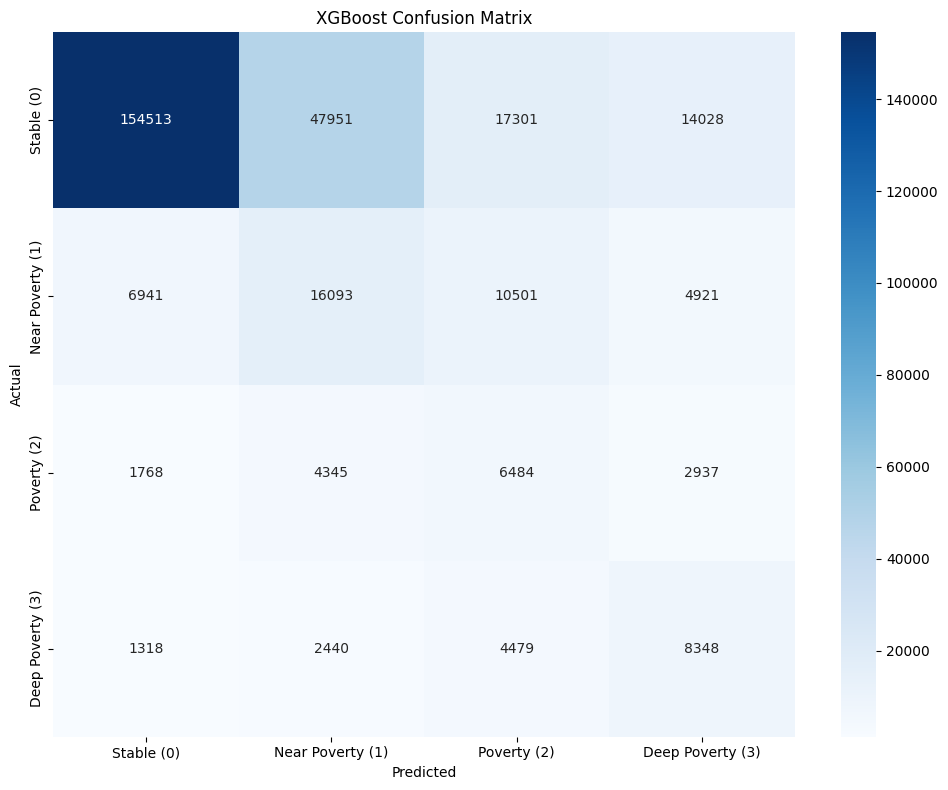

In [14]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('XGBoost Confusion Matrix')
plt.tight_layout()
plt.savefig('preprocessing_data/xgboost_confusion_matrix.png', dpi=150)
plt.show()

## 8. Feature Importance

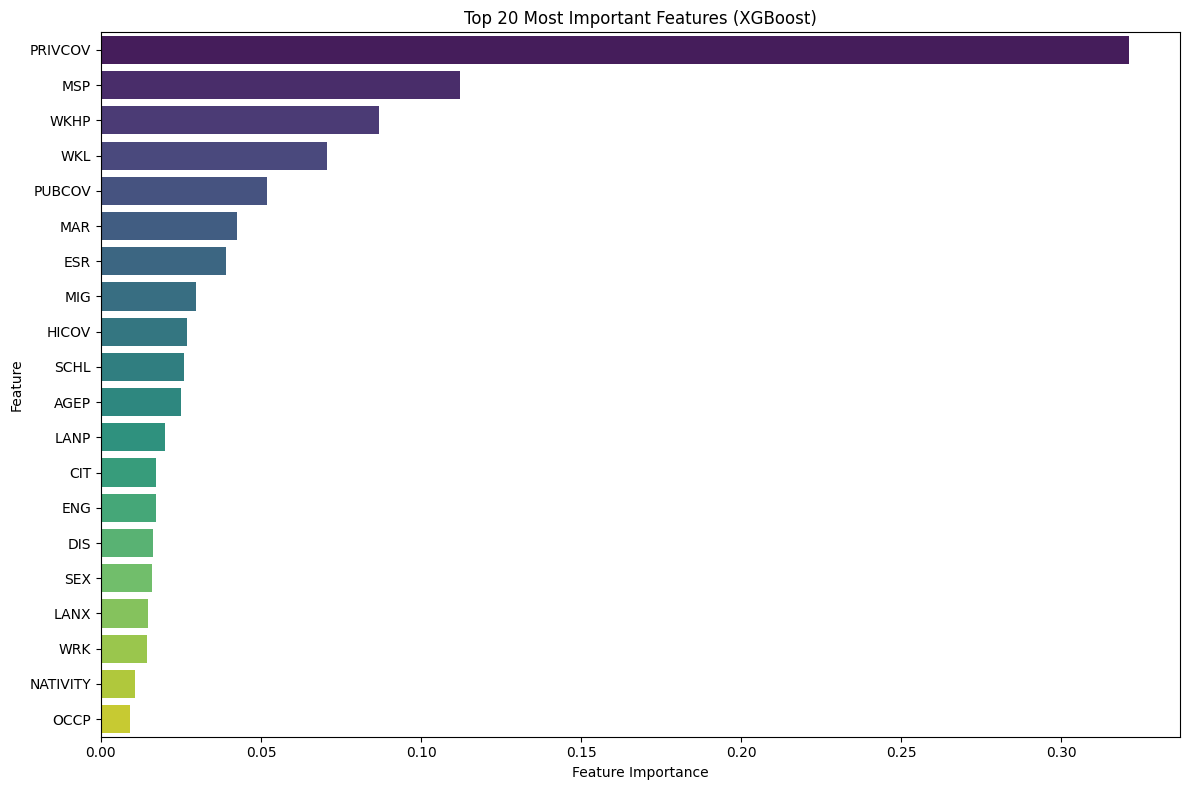


Top 20 Features:
 feature  importance
 PRIVCOV    0.321039
     MSP    0.112250
    WKHP    0.086720
     WKL    0.070609
  PUBCOV    0.051939
     MAR    0.042488
     ESR    0.039053
     MIG    0.029579
   HICOV    0.026892
    SCHL    0.025929
    AGEP    0.025170
    LANP    0.019965
     CIT    0.017358
     ENG    0.017204
     DIS    0.016396
     SEX    0.015950
    LANX    0.014596
     WRK    0.014271
NATIVITY    0.010566
    OCCP    0.008998


In [15]:
# Feature importance
importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=importance_df.head(20), x='importance', y='feature', palette='viridis')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 20 Most Important Features (XGBoost)')
plt.tight_layout()
plt.savefig('preprocessing_data/xgboost_feature_importance.png', dpi=150)
plt.show()

print("\nTop 20 Features:")
print(importance_df.head(20).to_string(index=False))

## 9. Compare with Baseline (Logistic Regression)

From your baseline notebook:
- Baseline Accuracy: ~70%
- Baseline struggled with Poverty (class 2) and Deep Poverty (class 3)

In [16]:
# Per-class performance comparison visualization
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred)

metrics_df = pd.DataFrame({
    'Class': class_names,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
})

print("\nPer-class metrics:")
print(metrics_df.to_string(index=False))


Per-class metrics:
           Class  Precision   Recall  F1-Score  Support
      Stable (0)   0.939060 0.660897  0.775798   233793
Near Poverty (1)   0.227209 0.418478  0.294514    38456
     Poverty (2)   0.167264 0.417407  0.238826    15534
Deep Poverty (3)   0.276113 0.503346  0.356607    16585


## 10. Alternative: Using XGBoost's Native Categorical Support

XGBoost 1.5+ supports native categorical features without label encoding.

In [17]:
# Alternative approach using native categorical support
# This requires pandas categorical dtype

def preprocess_native_categorical(df):
    """Use native categorical support in XGBoost (XGBoost 1.5+)"""
    df = df.copy()
    
    categorical_cols = [
        'PUMA', 'CIT', 'ENG', 'LANX', 'MAR', 'MIG', 'SEX', 'WKL', 'WRK',
        'DIS', 'ESR', 'HICOV', 'LANP', 'MSP', 'NATIVITY', 'OCCP', 'POBP',
        'PRIVCOV', 'PUBCOV', 'RAC1P', 'CA_Region', 'year'
    ]
    
    for col in categorical_cols:
        if col in df.columns:
            df[col] = df[col].astype('category')
    
    return df

# Example usage (uncomment to try):
df_train_cat = preprocess_native_categorical(df_train)
df_test_cat = preprocess_native_categorical(df_test)
model_native = xgb.XGBClassifier(enable_categorical=True, tree_method='hist', **params)

# Current results show low precision/recall for poverty classes.
# Let's try multiple strategies to improve performance.

In [18]:
# Install imbalanced-learn for resampling techniques
!pip install imbalanced-learn -q


[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: pip install --upgrade pip


## Class Imbalance Analysis

**Current Problem:**
- Class 0 (Stable): 75.8% of data → High precision (0.94), but model biased toward it
- Class 1 (Near Poverty): 13.4% → Low precision (0.23)
- Class 2 (Poverty): 5.4% → Very low precision (0.17)  
- Class 3 (Deep Poverty): 5.4% → Low precision (0.28)

**Strategies to try:**
1. **SMOTE** - Synthetic Minority Oversampling (create synthetic minority samples)
2. **Random Undersampling** - Reduce majority class size
3. **Combined Resampling** - SMOTE + Undersampling together
4. **Aggressive Class Weights** - Even higher weights for minority classes
5. **Threshold Optimization** - Tune prediction probability thresholds
6. **Binary Classification** - Simplify to Stable vs At-Risk (combine poverty classes)

In [19]:
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek, SMOTEENN
from collections import Counter

print("Original class distribution:")
print(Counter(y_train))
print(f"\nTotal samples: {len(y_train):,}")

Original class distribution:
Counter({0: 1114746, 1: 196583, 3: 79445, 2: 78995})

Total samples: 1,469,769


### Strategy 1: Random Undersampling
# Reduce majority class to balance with minority classes
# Fast and effective for large datasets

In [20]:
# Strategy 1: Undersample majority class to match total of minority classes
# This creates a more balanced dataset while preserving all minority samples

minority_total = y_train[y_train > 0].shape[0]  # Total of classes 1, 2, 3
print(f"Total minority samples (classes 1+2+3): {minority_total:,}")

# Undersample class 0 to match total minority count
undersample_strategy = {
    0: minority_total,  # Reduce stable to match sum of at-risk classes
    1: Counter(y_train)[1],  # Keep all
    2: Counter(y_train)[2],  # Keep all
    3: Counter(y_train)[3]   # Keep all
}

rus = RandomUnderSampler(sampling_strategy=undersample_strategy, random_state=42)
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

print(f"\nAfter undersampling:")
print(Counter(y_train_under))
print(f"Total samples: {len(y_train_under):,}")

Total minority samples (classes 1+2+3): 355,023

After undersampling:
Counter({0: 355023, 1: 196583, 3: 79445, 2: 78995})
Total samples: 710,046


In [21]:
# Train XGBoost on undersampled data
print("Training XGBoost on undersampled data...")

model_under = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=4,
    eval_metric='mlogloss',
    max_depth=6,
    learning_rate=0.1,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

model_under.fit(X_train_under, y_train_under, verbose=50)

# Evaluate
y_pred_under = model_under.predict(X_test)
print("\n=== Strategy 1: Undersampling Results ===")
print(classification_report(y_test, y_pred_under, target_names=class_names))

Training XGBoost on undersampled data...

=== Strategy 1: Undersampling Results ===
                  precision    recall  f1-score   support

      Stable (0)       0.91      0.79      0.85    233793
Near Poverty (1)       0.28      0.58      0.38     38456
     Poverty (2)       0.28      0.08      0.13     15534
Deep Poverty (3)       0.38      0.39      0.39     16585

        accuracy                           0.71    304368
       macro avg       0.46      0.46      0.44    304368
    weighted avg       0.77      0.71      0.73    304368



### Strategy 2: SMOTE + Undersampling Combined
# SMOTE creates synthetic minority samples, then we undersample majority
# This balances the dataset more evenly

In [22]:
# Strategy 2: SMOTE to oversample minorities, then undersample majority
# Target: Make all classes roughly equal

# First, undersample majority to make SMOTE faster
# Then apply SMOTE to bring minorities up

target_count = 200000  # Target ~200k samples per class

# Step 1: Undersample class 0
rus_step1 = RandomUnderSampler(
    sampling_strategy={0: target_count, 1: Counter(y_train)[1], 2: Counter(y_train)[2], 3: Counter(y_train)[3]},
    random_state=42
)
X_temp, y_temp = rus_step1.fit_resample(X_train, y_train)
print("After undersampling majority:")
print(Counter(y_temp))

# Step 2: SMOTE to oversample minorities to target_count
smote = SMOTE(
    sampling_strategy={1: target_count, 2: target_count, 3: target_count},
    random_state=42,
    k_neighbors=5
)
X_train_smote, y_train_smote = smote.fit_resample(X_temp, y_temp)

print("\nAfter SMOTE oversampling:")
print(Counter(y_train_smote))
print(f"Total samples: {len(y_train_smote):,}")

After undersampling majority:
Counter({0: 200000, 1: 196583, 3: 79445, 2: 78995})

After SMOTE oversampling:
Counter({0: 200000, 1: 200000, 2: 200000, 3: 200000})
Total samples: 800,000


In [23]:
# Train XGBoost on SMOTE-balanced data
print("Training XGBoost on SMOTE-balanced data...")

model_smote = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=4,
    eval_metric='mlogloss',
    max_depth=6,
    learning_rate=0.1,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

model_smote.fit(X_train_smote, y_train_smote, verbose=50)

# Evaluate
y_pred_smote = model_smote.predict(X_test)
print("\n=== Strategy 2: SMOTE + Undersampling Results ===")
print(classification_report(y_test, y_pred_smote, target_names=class_names))

Training XGBoost on SMOTE-balanced data...

=== Strategy 2: SMOTE + Undersampling Results ===
                  precision    recall  f1-score   support

      Stable (0)       0.94      0.67      0.78    233793
Near Poverty (1)       0.24      0.57      0.34     38456
     Poverty (2)       0.18      0.22      0.20     15534
Deep Poverty (3)       0.30      0.47      0.37     16585

        accuracy                           0.62    304368
       macro avg       0.41      0.48      0.42    304368
    weighted avg       0.77      0.62      0.67    304368



### Strategy 3: Threshold Tuning with Probability Outputs
# Instead of using default 0.5 threshold, optimize thresholds per class

In [24]:
# Strategy 3: Use probability outputs and adjust decision thresholds
# Train model with softprob to get probabilities

model_prob = xgb.XGBClassifier(
    objective='multi:softprob',  # Output probabilities
    num_class=4,
    eval_metric='mlogloss',
    max_depth=6,
    learning_rate=0.1,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

# Train on undersampled data (faster and often better)
model_prob.fit(X_train_under, y_train_under, verbose=False)

# Get probabilities
y_proba = model_prob.predict_proba(X_test)
print("Probability shape:", y_proba.shape)
print("Sample probabilities (first 5 rows):")
print(pd.DataFrame(y_proba[:5], columns=class_names).round(3))

Probability shape: (304368, 4)
Sample probabilities (first 5 rows):
   Stable (0)  Near Poverty (1)  Poverty (2)  Deep Poverty (3)
0       0.083             0.252        0.432             0.233
1       0.320             0.480        0.100             0.101
2       0.224             0.408        0.269             0.098
3       0.121             0.235        0.172             0.472
4       0.919             0.048        0.021             0.011


In [25]:
# Custom threshold tuning: Lower threshold for poverty classes to increase recall
# Default: predict class with highest probability
# Custom: boost poverty class probabilities by a factor

def predict_with_adjusted_thresholds(proba, boost_factors):
    """
    Adjust predictions by boosting minority class probabilities.
    boost_factors: dict mapping class_idx to multiplier
    """
    adjusted_proba = proba.copy()
    for class_idx, factor in boost_factors.items():
        adjusted_proba[:, class_idx] *= factor
    return np.argmax(adjusted_proba, axis=1)

# Boost poverty classes to increase their predictions
# Higher boost = more likely to predict that class
boost_factors = {
    0: 1.0,   # Stable - no change
    1: 1.5,   # Near Poverty - boost by 50%
    2: 2.0,   # Poverty - boost by 100%
    3: 2.0    # Deep Poverty - boost by 100%
}

y_pred_adjusted = predict_with_adjusted_thresholds(y_proba, boost_factors)

print("=== Strategy 3: Threshold-Adjusted Results ===")
print(f"Boost factors: {boost_factors}")
print(classification_report(y_test, y_pred_adjusted, target_names=class_names))

=== Strategy 3: Threshold-Adjusted Results ===
Boost factors: {0: 1.0, 1: 1.5, 2: 2.0, 3: 2.0}
                  precision    recall  f1-score   support

      Stable (0)       0.93      0.71      0.80    233793
Near Poverty (1)       0.25      0.62      0.36     38456
     Poverty (2)       0.24      0.15      0.19     15534
Deep Poverty (3)       0.33      0.45      0.38     16585

        accuracy                           0.65    304368
       macro avg       0.44      0.48      0.43    304368
    weighted avg       0.78      0.65      0.69    304368



### Strategy 4: Binary Classification (Stable vs At-Risk)
# Combine all poverty classes into one "At-Risk" class
# Often improves performance when distinguishing minority subclasses is difficult

In [26]:
# Create binary target: 0 = Stable, 1 = At-Risk (any poverty level)
y_train_binary = (y_train > 0).astype(int)
y_test_binary = (y_test > 0).astype(int)

print("Binary class distribution (Train):")
print(pd.Series(y_train_binary).value_counts())
print(f"\nAt-Risk percentage: {y_train_binary.mean()*100:.1f}%")

# Undersample for binary
rus_binary = RandomUnderSampler(sampling_strategy=0.5, random_state=42)  # 2:1 ratio
X_train_bin_under, y_train_bin_under = rus_binary.fit_resample(X_train, y_train_binary)
print(f"\nAfter undersampling: {Counter(y_train_bin_under)}")

Binary class distribution (Train):
poverty_risk_score
0    1114746
1     355023
Name: count, dtype: int64

At-Risk percentage: 24.2%

After undersampling: Counter({0: 710046, 1: 355023})


=== Strategy 4: Binary Classification Results ===
              precision    recall  f1-score   support

      Stable       0.93      0.72      0.81    233793
     At-Risk       0.47      0.81      0.60     70575

    accuracy                           0.75    304368
   macro avg       0.70      0.77      0.71    304368
weighted avg       0.82      0.75      0.76    304368



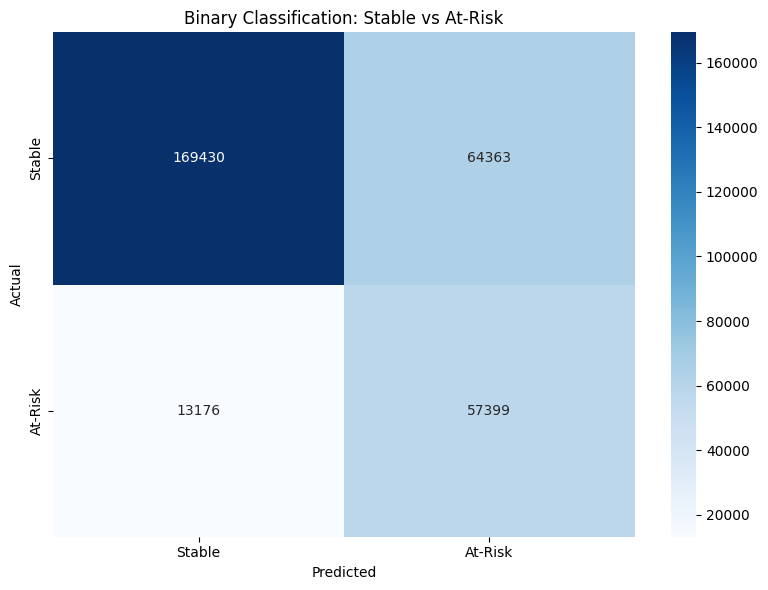

In [27]:
# Train binary classifier
model_binary = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    max_depth=6,
    learning_rate=0.1,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=2,  # Weight positive class (At-Risk) higher
    random_state=42,
    n_jobs=-1
)

model_binary.fit(X_train_bin_under, y_train_bin_under, verbose=False)

# Evaluate
y_pred_binary = model_binary.predict(X_test)
binary_names = ['Stable', 'At-Risk']

print("=== Strategy 4: Binary Classification Results ===")
print(classification_report(y_test_binary, y_pred_binary, target_names=binary_names))

# Confusion matrix for binary
cm_binary = confusion_matrix(y_test_binary, y_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_binary, annot=True, fmt='d', cmap='Blues',
            xticklabels=binary_names, yticklabels=binary_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Binary Classification: Stable vs At-Risk')
plt.tight_layout()
plt.show()

### Strategy Comparison Summary

=== Strategy Comparison ===
                  Strategy  Macro F1  Weighted F1  Balanced Accuracy
 Original (Sample Weights)  0.416436     0.664742           0.500032
             Undersampling  0.435433     0.725625           0.460725
     SMOTE + Undersampling  0.421655     0.673259           0.484068
        Threshold Adjusted  0.433607     0.693498           0.483105
Binary (Stable vs At-Risk)  0.705323     0.763487           0.769003


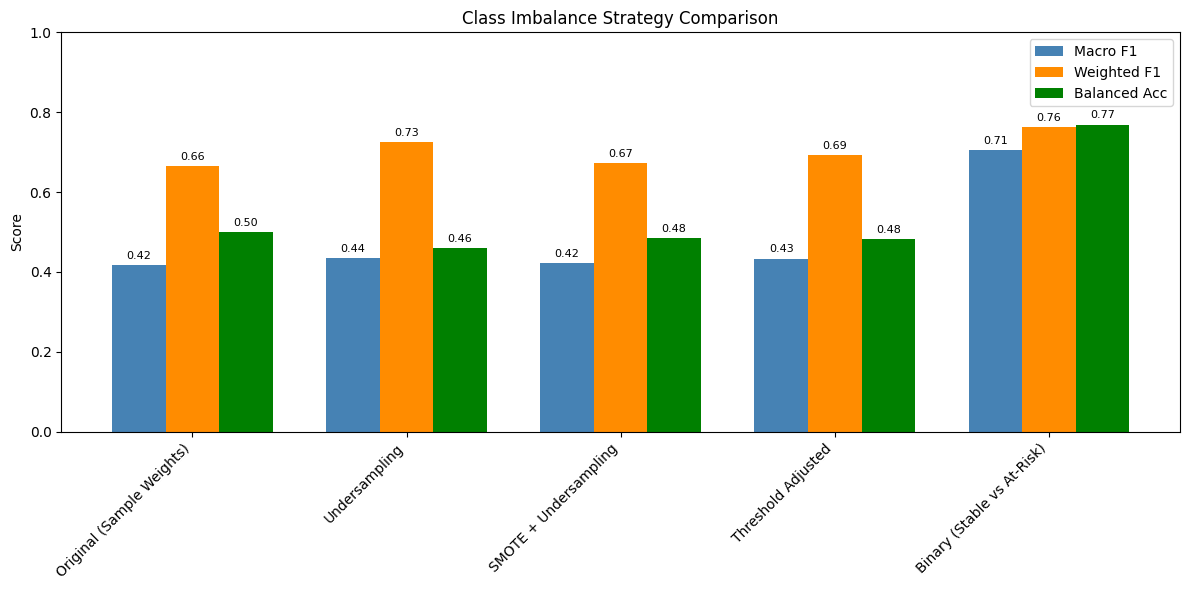

In [28]:
# Compare all strategies
from sklearn.metrics import f1_score, balanced_accuracy_score

results = []

# Original model with sample weights
results.append({
    'Strategy': 'Original (Sample Weights)',
    'Macro F1': f1_score(y_test, y_pred, average='macro'),
    'Weighted F1': f1_score(y_test, y_pred, average='weighted'),
    'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred)
})

# Undersampling
results.append({
    'Strategy': 'Undersampling',
    'Macro F1': f1_score(y_test, y_pred_under, average='macro'),
    'Weighted F1': f1_score(y_test, y_pred_under, average='weighted'),
    'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred_under)
})

# SMOTE
results.append({
    'Strategy': 'SMOTE + Undersampling',
    'Macro F1': f1_score(y_test, y_pred_smote, average='macro'),
    'Weighted F1': f1_score(y_test, y_pred_smote, average='weighted'),
    'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred_smote)
})

# Threshold adjusted
results.append({
    'Strategy': 'Threshold Adjusted',
    'Macro F1': f1_score(y_test, y_pred_adjusted, average='macro'),
    'Weighted F1': f1_score(y_test, y_pred_adjusted, average='weighted'),
    'Balanced Accuracy': balanced_accuracy_score(y_test, y_pred_adjusted)
})

# Binary (for comparison, compute on binary labels)
results.append({
    'Strategy': 'Binary (Stable vs At-Risk)',
    'Macro F1': f1_score(y_test_binary, y_pred_binary, average='macro'),
    'Weighted F1': f1_score(y_test_binary, y_pred_binary, average='weighted'),
    'Balanced Accuracy': balanced_accuracy_score(y_test_binary, y_pred_binary)
})

comparison_df = pd.DataFrame(results)
print("=== Strategy Comparison ===")
print(comparison_df.to_string(index=False))

# Plot comparison
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(comparison_df))
width = 0.25

bars1 = ax.bar(x - width, comparison_df['Macro F1'], width, label='Macro F1', color='steelblue')
bars2 = ax.bar(x, comparison_df['Weighted F1'], width, label='Weighted F1', color='darkorange')
bars3 = ax.bar(x + width, comparison_df['Balanced Accuracy'], width, label='Balanced Acc', color='green')

ax.set_ylabel('Score')
ax.set_title('Class Imbalance Strategy Comparison')
ax.set_xticks(x)
ax.set_xticklabels(comparison_df['Strategy'], rotation=45, ha='right')
ax.legend()
ax.set_ylim(0, 1)

for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('preprocessing_data/strategy_comparison.png', dpi=150)
plt.show()

## Recommendations

Based on the strategy comparison:

### For Multi-class Prediction (4 classes):
- **Best for balanced performance**: Use **Undersampling** or **SMOTE + Undersampling**
- These improve recall for poverty classes at the cost of some precision on Stable class
- Trade-off: Lower overall accuracy but better detection of at-risk individuals

### For Policy/Intervention Use Cases:
- Consider **Binary Classification (Stable vs At-Risk)** if:
  - The goal is to identify people who need intervention (any poverty level)
  - Distinguishing between poverty severity levels is less critical
  - You want higher overall accuracy and F1

### Key Insight:
The difficulty in classifying poverty sub-classes (Near Poverty vs Poverty vs Deep Poverty) suggests:
1. These classes may have significant feature overlap
2. The boundary between them (POVPIP thresholds) may be somewhat arbitrary
3. A two-stage approach could work: Binary classifier first, then severity classifier for At-Risk cases

In [29]:
# Save best models
model_under.save_model('preprocessing_data/xgboost_undersampled.json')
model_smote.save_model('preprocessing_data/xgboost_smote.json')
model_binary.save_model('preprocessing_data/xgboost_binary.json')

print("Models saved:")
print("  - preprocessing_data/xgboost_undersampled.json")
print("  - preprocessing_data/xgboost_smote.json")
print("  - preprocessing_data/xgboost_binary.json")

Models saved:
  - preprocessing_data/xgboost_undersampled.json
  - preprocessing_data/xgboost_smote.json
  - preprocessing_data/xgboost_binary.json


In [30]:
# Save the model
model.save_model('preprocessing_data/xgboost_poverty_model.json')
print("Model saved to preprocessing_data/xgboost_poverty_model.json")

Model saved to preprocessing_data/xgboost_poverty_model.json
